In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline

## A multi layer perceptron for a univariate time series 

In [2]:
# convert an array of values into a dataset matrix
def form_matrix(dataset, window_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_size-1):
        a = dataset[i:(i+window_size)]
        dataX.append(a)
        dataY.append(dataset[i + window_size])
    return np.array(dataX), np.array(dataY)

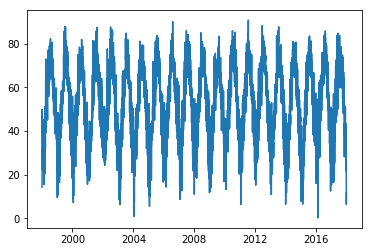

In [3]:
mean_temperature = pd.read_csv('temperature_data.csv', usecols=[2,3], engine='python')
mean_temperature['YEARMODA'] = pd.to_datetime(mean_temperature['YEARMODA'], format='%Y%m%d')
# print(mean_temperature)

plt.plot(mean_temperature['YEARMODA'],mean_temperature['TEMP'])
plt.show()

In [5]:
temperature_vals = mean_temperature['TEMP'].values
temperature_vals = temperature_vals.astype('float32')


np.random.seed(9)
"""split the data into training and teststing sets"""

train_size = int(len(temperature_vals) * 0.69)
test_size = len(temperature_vals) - train_size
print(train_size)
print(test_size)
print(len(temperature_vals))
train, test = temperature_vals[0:train_size-1], temperature_vals[train_size:len(temperature_vals)-1]

print(train, test)
"""reshape dataset to a matrix format and use a 2 day window for t-1 & t for predicting t+1"""
window_size = 2
trainX, trainY = form_matrix(train, window_size)
testX, testY = form_matrix(test, window_size)


"""create and fit Multilayer Perceptron model"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0,mode='min')
]
model = Sequential()
model.add(Dense(12, input_dim=window_size, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=20, verbose=0, callbacks=callbacks)
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
#print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))


5040
2265
7305
[14.2 33.9 45.4 ... 60.3 62.2 59.9] [57.9 58.8 56.9 ... 10.3  6.4 11. ]


/Users/srujansaik/miniconda3/envs/tensorf_env/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


5036/5036 [==============================] - 0s 17us/step
Train Score: 33.20 MSE (5.76 RMSE)
2261/2261 [==============================] - 0s 13us/step
Test Score: 37.44 MSE (6.12 RMSE)
Test Score: 37.44 MSE (6.12 RMSE)


In [6]:
# generate predictions for training

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(trainPredict)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(temperature_vals)
trainPredictPlot[:] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size] = [i for sublis in trainPredict for i in sublis]
# shift test predictions for plotting
testPredictPlot = np.empty_like(temperature_vals)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2)+1:len(temperature_vals)-3] = [i for sublis in testPredict for i in sublis]


[[33.245323]
 [42.247936]
 [50.062294]
 ...
 [61.34253 ]
 [62.111828]
 [59.84737 ]]


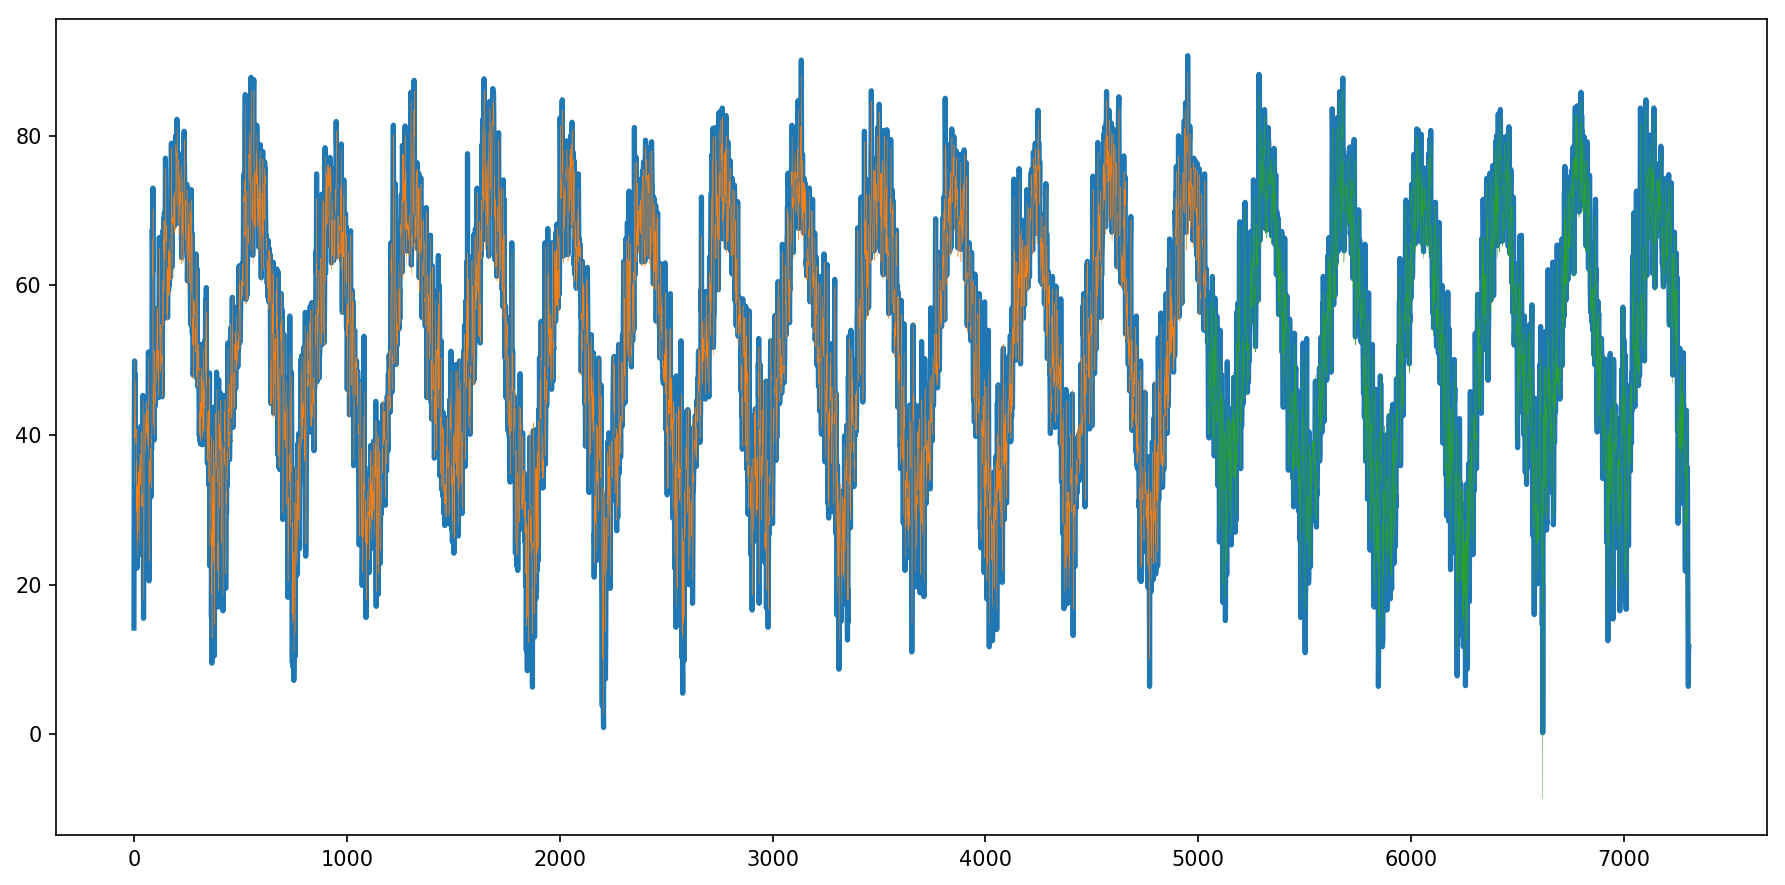

In [20]:
plt.figure(figsize=(12,6),dpi=150)
# plot baseline and predictions
plt.plot(temperature_vals, linewidth=2.5)
plt.plot(trainPredictPlot, linewidth=0.2)
plt.plot(testPredictPlot, linewidth=0.2)
plt.tight_layout()
plt.savefig("test.pdf")
plt.show()
